In [ ]:
# default_exp funcs.merfish_codenet

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
import torch.nn as nn
import torch.nn.functional as F
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.matching import *
from decode_fish.engine.gmm_loss import *
from decode_fish.engine.microscope import add_pos_noise
from sklearn.utils import resample
import wandb

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_9/z_facs:Falsexnorm:none//train.yaml')

In [ ]:
test_csv = pd.read_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/qual_nets/starfish_test.csv')
test_csv['int_ratio'] = zero_int_ch(test_csv, codebook)['int_ratio']

In [ ]:
cfg.genm.foci.n_foci_avg = 0
cfg.training.bs = 20
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
from decode_fish.funcs.exp_specific import *
codebook, targets = get_starfish_codebook()

In [ ]:
post_proc.codebook = expand_codebook(codebook)

In [ ]:
# export
class code_net(nn.Module):

    def __init__(self, n_inputs=53, n_outputs=1):
        super(code_net, self).__init__()
        
        self.layers = nn.Sequential(
          nn.Linear(n_inputs, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          nn.Linear(32, n_outputs)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
class conv_net(nn.Module):

    def __init__(self, n_metrics=5, n_chs=16, bn=False):
        super(conv_net, self).__init__()
    
        self.n_chs = n_chs
        self.n_metrics = n_metrics

        self.int_c1 = nn.Linear(3, 10).cuda()
        self.int_c2 = nn.Linear(10, 10).cuda()
        self.int_c3 = nn.Linear(10, 1).cuda()
        
        if bn:
            self.layers = nn.Sequential(
              nn.Linear(self.n_metrics + self.n_chs, 256),
              nn.BatchNorm1d(128),
              nn.ReLU(),
              nn.Linear(128, 64),
              nn.BatchNorm1d(64),
              nn.ReLU(),
              nn.Linear(64, 32),
              nn.BatchNorm1d(32),
              nn.ReLU(),
              nn.Linear(32, 1)
            )
        else:
            self.layers = nn.Sequential(
              nn.Linear(self.n_metrics + self.n_chs, 256),
              nn.ReLU(),
              nn.Linear(256, 128),
              nn.ReLU(),
              nn.Linear(128, 64),
              nn.ReLU(),
              nn.Linear(64, 32),
              nn.ReLU(),
              nn.Linear(32, 1)
            )            
        
    def forward(self, x):
        
        intm_ints_bin = x[:, -3*self.n_chs:].reshape(-1, 3, self.n_chs).permute(0,2,1)
        f_int = F.relu(self.int_c1(intm_ints_bin))
        f_int = F.relu(self.int_c2(f_int))
        f_int = F.relu(self.int_c3(f_int)[:,:,0])
        
        dense_inp = torch.cat([x[:, :self.n_metrics], f_int], 1)
        return self.layers(dense_inp)   

# net = code_net().cuda()
net = conv_net(6, 16).cuda()

def input_from_df(df, codebook):
          
    n_ch = len(codebook[0])
    input_keys = ['prob', 'z', 'x_sig','y_sig','z_sig','int_ratio'] + [f'int_sig_{i}' for i in range(n_ch)]  + [f'int_{i}' for i in range(n_ch)]
    offsets = [0.75, 50, 20., 20., 15.,2.] + n_ch*[1.] + n_ch*[0.]
    scales = [1., 100., 20., 20., 15.,2.] + n_ch*[2.] + n_ch*[5.]
    inp_arr = df[input_keys].values
    inp_arr = (inp_arr - np.array(offsets))/np.array(scales)
    
    inp_arr = np.concatenate([inp_arr, codebook[df['code_inds'].values]], 1)
    
    return torch.tensor(inp_arr, dtype=torch.float32).cuda()

In [ ]:
# export
def train_metric_net(net, model, decode_dl, post_proc, micro, point_process, cfg):

    bce = torch.nn.BCEWithLogitsLoss()
    opt = torch.optim.AdamW(net.parameters(), lr = 4e-3)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
    test_csv = pd.read_csv(cfg.test_csv)
    codebook, targets = hydra.utils.instantiate(cfg.codebook)
    model.cuda()
    test_csv['int_ratio'] = sel_int_ch(test_csv, codebook)['int_ratio']
    
    ignores = [int(a) for a in str(cfg.ignore)]
    zero_out = torch.ones(54).cuda()
    zero_out[ignores] = 0
    
    for i in tqdm(range(cfg.num_iters)):

        with torch.no_grad():

            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'],
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            background = background * micro.get_ch_mult()
            if cfg.sim.bg_estimation.shuffle_ch:
                background = background.index_select(1, torch.randperm(background.shape[1]).cuda())

            if cfg.genm.microscope.col_shifts_enabled  :
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
            else:
                zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

            local_rate *= cfg.rate_fac
            sim_vars = point_process.sample(local_rate[:,0])

            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
            cond = sim_vars[-1] < len(codebook)
            cb_cool = torch.repeat_interleave(cond, cond * (cfg.genm.exp_type.n_bits - 1) + 1)
            ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool] = add_pos_noise([ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool]],
                                                                                       [cfg.genm.pos_noise.pos_noise_xy*0.5, cfg.genm.pos_noise.pos_noise_xy*0.5, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
            xsim = micro(*ch_inp, add_noise=True)

            if cfg.genm.phasing:

                phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
                phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
                xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)

            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
            net_inp = torch.concat([x,colshift_crop], 1)

            gt_vars = sim_vars[:-2]
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_df = gt_df[gt_df['code_inds'] < len(codebook)]

            res_dict = model(net_inp.cuda())
            res_dict = model.tensor_to_dict(res_dict)
            pred_df = post_proc.get_df(res_dict)
            pred_df = pred_df[pred_df['code_inds'] < len(codebook)]
            pred_df['gene'] = targets[pred_df['code_inds']]
    #         pred_df = sel_int_ch(pred_df, codebook)

            perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)

            pred_df.loc[:, 'class'] = 1
            pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
            pred_df['int_ratio'] = zero_int_ch(pred_df, codebook)['int_ratio'].values

        opt.zero_grad()

        ''''''
        if cfg.resample:
            df_majority = pred_df[pred_df['class']==0]
            df_minority = pred_df[pred_df['class']==1]

            df_maj_down = resample(df_majority, replace=True, n_samples=len(df_minority)*2)

            pred_df = pd.concat([df_minority, df_maj_down])
        ''''''

        net_inp = input_from_df(pred_df, codebook)
        net_inp *= zero_out[None]
        net_out = net(net_inp)

        net_tar = torch.tensor(pred_df['class'].values, dtype=torch.float32).cuda()
        loss = bce(net_out, net_tar[:,None])

        test_csv['net_score'] = torch.sigmoid(net(input_from_df(test_csv, codebook)).detach().cpu())

        loss.backward()

        opt.step()
        sched.step()

        wandb.log({'loss': loss.item()}, step=i)
        wandb.log({'N_blanks': test_csv.nsmallest(12555, 'net_score')['class'].sum()}, step=i)

        if i % 20 == 0 and cfg.save_file is not None:
            torch.save(net, cfg.save_file)
            
    wandb.finish()

In [ ]:
num_iters = 500
i = 0

micro.psf_noise = 0.0

bce = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(net.parameters(), lr = 4e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
loss_col = []

model.eval().cuda()

code_weight = torch.ones(len(post_proc.codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                   codebook=post_proc.codebook, int_option=cfg.training.int_option, code_weight=code_weight)

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
        if cfg.sim.bg_estimation.shuffle_ch:
            background = background.index_select(1, torch.randperm(background.shape[1]).cuda())
        
        local_rate *= 5
        if cfg.genm.microscope.col_shifts_enabled  :
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        else:
            zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

        sim_vars = point_process.sample(local_rate[:,0])
        
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
        cond = sim_vars[-1] < len(codebook)
        cb_cool = torch.repeat_interleave(cond, cond * (cfg.genm.exp_type.n_bits - 1) + 1)
        ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool] = add_pos_noise([ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool]], 
                                                                                   [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)
        
        if cfg.genm.phasing:

            phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
            phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
            xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)

        x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
        gt_df = gt_df[gt_df['code_inds'] < len(codebook)]

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df = pred_df[pred_df['code_inds'] < len(codebook)]
        pred_df['gene'] = targets[pred_df['code_inds']]
#         pred_df = sel_int_ch(pred_df, codebook)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        pred_df['int_ratio'] = zero_int_ch(pred_df, codebook)['int_ratio'].values

    opt.zero_grad()

    ''''''
#     df_majority = pred_df[pred_df['class']==0]
#     df_minority = pred_df[pred_df['class']==1]

#     df_maj_down = resample(df_majority, replace=True, n_samples=len(df_minority)*2)

#     pred_df = pd.concat([df_minority, df_maj_down])    
    ''''''
    
    net_inp = input_from_df(pred_df, codebook)
    net_out = net(net_inp)

    net_tar = torch.tensor(pred_df['class'].values, dtype=torch.float32).cuda()
    loss = bce(net_out, net_tar[:,None])
    print(loss.item())
    
    test_csv['net_score'] = torch.sigmoid(net(input_from_df(test_csv, codebook)).detach().cpu())
    print(test_csv.nsmallest(12555, 'net_score')['class'].sum())
    torch.save(net, '../data/qual_nets/net1.pkz')

    loss.backward()

    opt.step()
    sched.step()

    loss_col.append(loss.item())

  0%|▎                                                                                                                                                   | 1/500 [00:05<49:36,  5.96s/it]

0.6658934354782104
107


  0%|▌                                                                                                                                                   | 2/500 [00:10<42:07,  5.08s/it]

0.6467674374580383
330


  1%|▉                                                                                                                                                   | 3/500 [00:16<45:33,  5.50s/it]

0.6302918791770935
299


  1%|█▏                                                                                                                                                  | 4/500 [00:21<44:29,  5.38s/it]

0.6091418266296387
301


  1%|█▍                                                                                                                                                  | 5/500 [00:27<46:48,  5.67s/it]

0.563991129398346
272


  1%|█▊                                                                                                                                                  | 6/500 [00:32<43:15,  5.25s/it]

0.5137714147567749
241


  1%|██                                                                                                                                                  | 7/500 [00:37<43:12,  5.26s/it]

0.4423367381095886
191


  2%|██▎                                                                                                                                                 | 8/500 [00:42<42:12,  5.15s/it]

0.4055396020412445
123


  2%|██▋                                                                                                                                                 | 9/500 [00:47<42:44,  5.22s/it]

0.4081571102142334
67


  2%|██▉                                                                                                                                                | 10/500 [00:54<46:03,  5.64s/it]

0.46252334117889404
24


  2%|███▏                                                                                                                                               | 11/500 [00:59<44:56,  5.51s/it]

0.40869057178497314
10


  2%|███▌                                                                                                                                               | 12/500 [01:05<45:57,  5.65s/it]

0.3963662087917328
7


  3%|███▊                                                                                                                                               | 13/500 [01:10<45:09,  5.56s/it]

0.34834638237953186
9


  3%|████                                                                                                                                               | 14/500 [01:17<46:22,  5.73s/it]

0.3725771903991699
8


  3%|████▍                                                                                                                                              | 15/500 [01:21<43:33,  5.39s/it]

0.3235606551170349
9


  3%|████▋                                                                                                                                              | 16/500 [01:27<44:36,  5.53s/it]

0.35687169432640076
9


  3%|████▉                                                                                                                                              | 17/500 [01:32<43:42,  5.43s/it]

0.36044842004776
9


  4%|█████▎                                                                                                                                             | 18/500 [01:39<46:00,  5.73s/it]

0.3543606698513031
11


  4%|█████▌                                                                                                                                             | 19/500 [01:45<47:59,  5.99s/it]

0.4005882740020752
12


  4%|█████▉                                                                                                                                             | 20/500 [01:50<45:30,  5.69s/it]

0.34215378761291504
12


  4%|██████▏                                                                                                                                            | 21/500 [01:56<45:04,  5.65s/it]

0.3260084092617035
11


  4%|██████▍                                                                                                                                            | 22/500 [02:01<43:48,  5.50s/it]

0.3474278748035431
11


  5%|██████▊                                                                                                                                            | 23/500 [02:08<47:56,  6.03s/it]

0.3873015344142914
12


  5%|███████                                                                                                                                            | 24/500 [02:15<50:43,  6.39s/it]

0.3916091024875641
12


  5%|███████▎                                                                                                                                           | 25/500 [02:21<47:31,  6.00s/it]

0.3158445954322815
12


  5%|███████▋                                                                                                                                           | 26/500 [02:27<47:45,  6.05s/it]

0.33302921056747437
12


  5%|███████▉                                                                                                                                           | 27/500 [02:33<48:36,  6.17s/it]

0.4029085040092468
12


  6%|████████▏                                                                                                                                          | 28/500 [02:39<48:29,  6.16s/it]

0.34636440873146057
12


  6%|████████▌                                                                                                                                          | 29/500 [02:44<43:49,  5.58s/it]

0.3438092768192291
12


  6%|████████▊                                                                                                                                          | 30/500 [02:49<44:08,  5.63s/it]

0.3273528516292572
14


  6%|█████████                                                                                                                                          | 31/500 [02:56<46:34,  5.96s/it]

0.3557707667350769
15


  6%|█████████▍                                                                                                                                         | 32/500 [03:00<42:54,  5.50s/it]

0.2963816523551941
16


  7%|█████████▋                                                                                                                                         | 33/500 [03:07<44:54,  5.77s/it]

0.34079065918922424
16


  7%|█████████▉                                                                                                                                         | 34/500 [03:13<45:15,  5.83s/it]

0.36372682452201843
17


  7%|██████████▎                                                                                                                                        | 35/500 [03:19<46:10,  5.96s/it]

0.3432616591453552
19


  7%|██████████▌                                                                                                                                        | 36/500 [03:24<43:19,  5.60s/it]

0.2971508204936981
19


  7%|██████████▉                                                                                                                                        | 37/500 [03:29<42:18,  5.48s/it]

0.27579402923583984
19


  8%|███████████▏                                                                                                                                       | 38/500 [03:35<42:54,  5.57s/it]

0.36080339550971985
19


  8%|███████████▍                                                                                                                                       | 39/500 [03:41<43:46,  5.70s/it]

0.3193778395652771
19


  8%|███████████▊                                                                                                                                       | 40/500 [03:45<40:40,  5.31s/it]

0.26492127776145935
19


  8%|████████████                                                                                                                                       | 41/500 [03:52<44:37,  5.83s/it]

0.3566470146179199
20


  8%|████████████▎                                                                                                                                      | 42/500 [03:58<45:12,  5.92s/it]

0.32311150431632996
20


  9%|████████████▋                                                                                                                                      | 43/500 [04:04<45:02,  5.91s/it]

0.35395190119743347
21


  9%|████████████▉                                                                                                                                      | 44/500 [04:11<47:15,  6.22s/it]

0.36340853571891785
22


  9%|█████████████▏                                                                                                                                     | 45/500 [04:16<44:45,  5.90s/it]

0.31183579564094543
22


  9%|█████████████▌                                                                                                                                     | 46/500 [04:23<45:16,  5.98s/it]

0.3238610029220581
22


  9%|█████████████▊                                                                                                                                     | 47/500 [04:28<43:53,  5.81s/it]

0.30671557784080505
22


 10%|██████████████                                                                                                                                     | 48/500 [04:33<42:48,  5.68s/it]

0.3372621536254883
22


 10%|██████████████▍                                                                                                                                    | 49/500 [04:38<41:02,  5.46s/it]

0.31475067138671875
22


 10%|██████████████▋                                                                                                                                    | 50/500 [04:43<38:15,  5.10s/it]

0.3295568525791168
22


 10%|██████████████▋                                                                                                                                    | 50/500 [04:46<43:02,  5.74s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(net, '../data/qual_nets/net1.pkz')

In [ ]:
plt.plot(loss_col)

In [ ]:
logr_coefs = {'x_sig': 0.03, 'y_sig': 0.03, 'z_sig': 0.0, 'prob': -2.3}
def log_reg(df, weights={}):
    
    df = df.copy()
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

(array([  29.,  146.,  487., 1183., 1793., 1893., 1223.,  513.,  155.,
          30.]),
 array([-50., -30., -10.,  10.,  30.,  50.,  70.,  90., 110., 130., 150.],
       dtype=float32),
 <BarContainer object of 10 artists>)

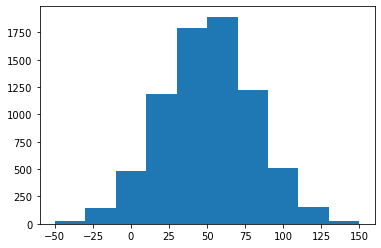

In [ ]:
plt.hist(cpu(torch.clamp(torch.randn(len(sim_vars[4])) * 30 + 50, -50, 150)))

In [ ]:
gt_dfs = []
pred_dfs = []

for i in tqdm(range(10)):
    
    with torch.no_grad():

        ret_dict = next(iter(decode_dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
        zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
        background = background * micro.get_ch_mult()
#         local_rate *= 2
        if cfg.genm.microscope.col_shifts_enabled  :
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        else:
            zcrop, ycrop, xcrop, colshift_crop = None, None, None, None

        sim_vars = point_process.sample(local_rate[:,0])
        
        ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
        cond = sim_vars[-1] < len(codebook)
        cb_cool = torch.repeat_interleave(cond, cond * (cfg.genm.exp_type.n_bits - 1) + 1)
        ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool] = add_pos_noise([ch_inp[1][cb_cool], ch_inp[2][cb_cool], ch_inp[3][cb_cool]], 
                                                                                   [cfg.genm.pos_noise.pos_noise_xy*2, cfg.genm.pos_noise.pos_noise_xy*2, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
        xsim = micro(*ch_inp, add_noise=True)
        
        if cfg.genm.phasing:

            phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
            phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
            xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)

        x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

        colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        net_inp = torch.concat([x,colshift_crop], 1)
        
        gt_vars = sim_vars[:-2] 
        gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
        gt_df = gt_df[gt_df['code_inds'] < len(codebook)]

        res_dict = model(net_inp.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df = pred_df[pred_df['code_inds'] < len(codebook)]
        pred_df['gene'] = targets[pred_df['code_inds']]
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df.loc[:, 'class'] = 1
        pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        
        pred_df = log_reg(pred_df, logr_coefs)
        
        pred_dfs.append(pred_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]


In [ ]:
net.eval()
res_df = cat_emitter_dfs(pred_dfs, decode_dl.batch_size)
inp = input_from_df(res_df, codebook)
# inp[:,-22:] *= 0
res_df['net_score'] = cpu(torch.sigmoid(net(inp)))

KeyError: "['int_ratio'] not in index"

In [ ]:
res_df = sel_int_ch(res_df, codebook)

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k, n_max=8000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

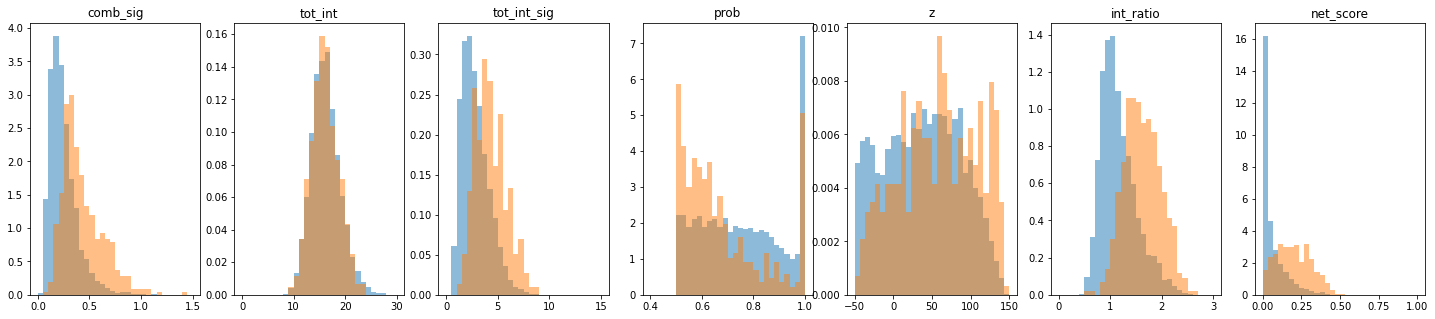

In [ ]:
# res_df = sel_int_ch(res_df, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio', 'net_score']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31), np.linspace(0.,1., 31)]
plt.figure(figsize=(25,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[res_df['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

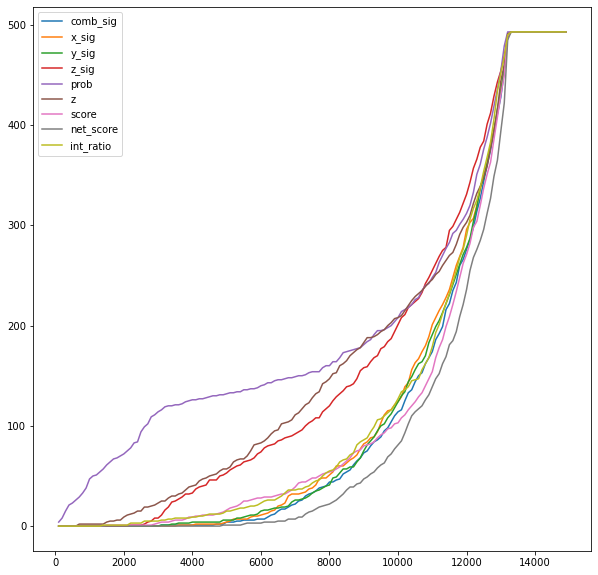

In [ ]:
plt.figure(figsize=(10,10))
for k in ['comb_sig','x_sig','y_sig','z_sig','prob','z','score','net_score','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(res_df, k, n_max=15000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
Converted stephan_exon-spine (2).ipynb.
